# SLC

## Imports

In [13]:
import os
from datetime import datetime
import inspect
import gc
import math
import time
import spectral
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from scipy import ndimage
import scipy.io as sio
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,recall_score,cohen_kappa_score,accuracy_score
from torchmetrics.classification import MulticlassConfusionMatrix
from torchmetrics.functional import dice, jaccard_index
from torchinfo import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import IncrementalPCA
from pytorch_wavelets import DWTForward
#from tqdm import tqdm
from tqdm.notebook import tqdm
import random
#from torchviz import make_dot
#import h5py
import gc
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

from sklearn.utils.class_weight import compute_class_weight
from torchvision import transforms

import hypso
from hypso import Hypso1
from hypso import Hypso2
from hypso.load import load_l1a_nc_cube
from hypso.load import load_l1b_nc_cube
from hypso.load import load_l1c_nc_cube
from hypso.load import load_l1d_nc_cube
from hypso.write import write_l1b_nc_file
from hypso.write import write_l1c_nc_file
from hypso.write import write_l1d_nc_file
from hypso.spectral_analysis import get_closest_wavelength_index


from torch.utils.data import ConcatDataset
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

start_time = time.time() 

# Device
torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Is CUDA available?:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("Current CUDA device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available.")

print("Allocated GPU memory:", torch.cuda.memory_allocated())
print("Cached GPU memory:", torch.cuda.memory_reserved())

Is CUDA available?: True
Current CUDA device: 0
Device name: NVIDIA GeForce RTX 3080 Ti
Allocated GPU memory: 68213760
Cached GPU memory: 333447168


## Functions

In [14]:

def get_model_summary(model, input_size):
    return str(summary(model, input_size=input_size))

# Get the model code
def get_model_code(model):
    return str(model)

#Get training output
def get_training_output(training_log):
    return str(training_log)

def save_training_info(model, configs, training_log, best_val_acc):
    now = datetime.now()
    date_time_str = now.strftime("%d_%m_%H_%M")
    file_name = f"{date_time_str}_acc_{best_val_acc:.4f}.txt"

    experiments_dir = "C:\\WaveSeg\\experiments"  # Use the full path
    if not os.path.exists(experiments_dir):
        os.makedirs(experiments_dir)    

    file_path = os.path.join(experiments_dir, file_name)  # Construct the full file path

    with open(file_path, "w", encoding="utf-8") as f:  # Specify UTF-8 encoding
        f.write(f"DATE: {now.strftime('%d/%m/%Y %H:%M')}\n")
        f.write(f"MODEL ACCURACY: {best_val_acc:.4f}\n\n")

        f.write("CONFIGURATIONS:\n\n")
        for key, value in configs.items():
            f.write(f"{key} = {value}\n")

        f.write("\nTRAINING OUTPUT:\n\n")
        # Modified part: Write each line from training_log separately
        for line in training_log:
            f.write(line + "\n")

        f.write("\n\nMODEL SUMMARY:\n\n")
        # Assuming an input size for the summary.  Adjust as needed.
        input_size = (1, configs['num_components'], configs['PATCH_SIZE'], configs['PATCH_SIZE'])
        f.write(get_model_summary(model, input_size))

        f.write("\n\nMODEL CODE:\n\n")
        f.write(get_model_code(model))



def get_best_model(acc_list, epoch_list, save_path):
    acc_list = np.array(acc_list)
    epoch_list = np.array(epoch_list)
    best_index = np.argwhere(acc_list == np.max(acc_list))[-1].item()
    best_epoch = epoch_list[best_index]
    best_acc = acc_list[best_index]
    file_name = f"{datetime.now().strftime('%d_%m_%H_%M')}_acc_{best_acc:.4f}_EPOCH_{best_epoch}.pth"  # Naming format from training code.
    best_model_path = os.path.join(save_path, file_name)
    print(f"best model:{file_name}")

    experiments_dir = "C:\\WaveSeg\\experiments"  # Use the full path

    # Find and move the previous best model if it exists
    previous_best_model = None
    for f in os.listdir(save_path):
        if f.endswith('.pth') and '_EPOCH_' in f and f != file_name: #Look for the best model from the previous training session
            if previous_best_model is None:
                previous_best_model = os.path.join(save_path, f)
            else:
                os.remove(os.path.join(save_path, f)) #delete all non best epoch models from previous training session.
        elif f.endswith('.pth') and '_EPOCH_' not in f and f != file_name: #Delete all other epoch models from the previous training session.
            os.remove(os.path.join(save_path, f))

    if previous_best_model:
        new_model_path = os.path.join(experiments_dir, os.path.basename(previous_best_model))
        os.rename(previous_best_model, new_model_path)

        # Move corresponding text file if it exists
        txt_file_name = os.path.splitext(os.path.basename(previous_best_model))[0] + ".txt"
        old_txt_path = os.path.join(save_path, txt_file_name)
        if os.path.exists(old_txt_path):
            new_txt_path = os.path.join(experiments_dir, os.path.basename(txt_file_name))
            os.rename(old_txt_path, new_txt_path)

    return best_model_path


# First, add the focal loss implementation
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce_loss = torch.nn.CrossEntropyLoss(reduction='none')
        
    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss
        

### Dimensionality Reduction (PCA)

In [15]:
def batch_processing(files, num_pca_components=None, batch_size=4, processing_type="pca"):
    processed_images = []
    total_batches = math.ceil(len(files) / batch_size)

    with tqdm(total=len(files), desc=f"Processing {processing_type.upper()} for images", unit="image") as pbar:
        for batch_idx in range(total_batches):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, len(files))
            batch_files = files[start_idx:end_idx]

            batch_results = []
            for img in batch_files:
                reshaped_data = img.reshape(-1, img.shape[-1])  # Flatten for PCA

                if processing_type == "pca":
                    pca = PCA(n_components=num_pca_components)
                    transformed_data = pca.fit_transform(reshaped_data)

                elif processing_type == "none":
                    transformed_data = reshaped_data  # No transformation

                # Reshape back to original (H, W, C) format
                num_components = transformed_data.shape[1]
                transformed_data = transformed_data.reshape(img.shape[0], img.shape[1], num_components)

                batch_results.append(transformed_data)
                pbar.update(1)

            processed_images.extend(batch_results)
            gc.collect()  # Free memory

    return np.array(processed_images)


### Patch Extraction

In [16]:
def apply_padding(image, patch_size, stride, mode='reflect'):
    height, width, channels = image.shape

    # Calculate padding needed
    pad_h = (patch_size - (height % stride)) % patch_size
    pad_w = (patch_size - (width % stride)) % patch_size

    # Apply padding to height and width
    padded_image = np.pad(image, ((0, pad_h), (0, pad_w), (0, 0)), mode=mode)

    return padded_image

def extract_patches(image, patch_size, stride):
    if len(image.shape) == 2:  
        H, W = image.shape
        C = None
    else:  
        H, W, C = image.shape

    patches = []
    indices = []

    for i in range(0, H - patch_size + 1, stride):
        for j in range(0, W - patch_size + 1, stride):
            if C is None: 
                patch = image[i:i+patch_size, j:j+patch_size]  
            else:  
                patch = image[i:i+patch_size, j:j+patch_size, :]
            patches.append(patch)
            indices.append((i, j))

    return np.array(patches), indices



class PatchSet(Dataset):
    def __init__(self, images, labels=None, patch_size=None, stride=None, is_pred=False):
        self.images = images
        self.labels = labels
        self.patch_size = patch_size
        self.stride = stride
        self.is_pred = is_pred
        
        # Pre-calculate patch indices for each image
        self.patch_indices = []
        self.image_to_patch_map = []
        
        for img_idx, img in enumerate(images):
            h, w = img.shape[:2]
            img_patches = []
            
            for i in range(0, h - patch_size + 1, stride):
                for j in range(0, w - patch_size + 1, stride):
                    self.patch_indices.append((img_idx, i, j))
                    
        self.total_patches = len(self.patch_indices)
                    
    def __len__(self):
        return self.total_patches
    
    def __getitem__(self, idx):
        img_idx, i, j = self.patch_indices[idx]
        img = self.images[img_idx]
        patch_size = self.patch_size
        
        # Extract the patch only when needed
        if len(img.shape) == 2:
            patch = img[i:i+patch_size, j:j+patch_size]
            # Add channel dimension if grayscale
            patch = np.expand_dims(patch, axis=0)
        else:
            patch = img[i:i+patch_size, j:j+patch_size, :]
            # Move channels to first dimension (C, H, W)
            patch = np.transpose(patch, (2, 0, 1))
            
        # Convert only this patch to tensor
        patch_tensor = torch.tensor(patch, dtype=torch.float32)
        
        if not self.is_pred and self.labels is not None:
            label = self.labels[img_idx]
            label_patch = label[i:i+patch_size, j:j+patch_size]
            label_tensor = torch.tensor(label_patch, dtype=torch.long)
            return patch_tensor, label_tensor
        
        return patch_tensor

    
class TestPatchSet(Dataset):
    def __init__(self, images, patch_size=None, stride=None):
        self.images = images
        self.patch_size = patch_size
        self.stride = stride
        
        # Pre-calculate patch indices for each image
        self.patch_indices = []
        
        for img_idx, img in enumerate(images):
            h, w = img.shape[:2]
            
            for i in range(0, h - patch_size + 1, stride):
                for j in range(0, w - patch_size + 1, stride):
                    self.patch_indices.append((img_idx, i, j))
                    
    def __len__(self):
        return len(self.patch_indices)
    
    def __getitem__(self, idx):
        img_idx, i, j = self.patch_indices[idx]
        img = self.images[img_idx]
        patch_size = self.patch_size
        
        # Extract the patch only when needed
        if len(img.shape) == 2:
            patch = img[i:i+patch_size, j:j+patch_size]
            # Add channel dimension if grayscale
            patch = np.expand_dims(patch, axis=0)
        else:
            patch = img[i:i+patch_size, j:j+patch_size, :]
            # Move channels to first dimension (C, H, W)
            patch = np.transpose(patch, (2, 0, 1))
            
        # Convert only this patch to tensor
        patch_tensor = torch.tensor(patch, dtype=torch.float32)
        
        return patch_tensor, img_idx
    
def reconstruct_image_with_confidence(patches, confidence_scores, original_shape, patch_size=None, stride=None):
    
    H, W = original_shape
    reconstructed = np.zeros((H, W), dtype=np.float32)
    weights = np.zeros((H, W), dtype=np.float32)

    patch_idx = 0
    for i in range(0, H - patch_size + 1, stride):
        for j in range(0, W - patch_size + 1, stride):
            # Add weighted vote for each pixel
            patch_pred = patches[patch_idx]
            patch_conf = confidence_scores[patch_idx]
            
            reconstructed[i:i+patch_size, j:j+patch_size] += patch_pred * patch_conf
            weights[i:i+patch_size, j:j+patch_size] += patch_conf
            
            patch_idx += 1

    # Normalize by weights
    mask = weights > 0
    reconstructed[mask] = reconstructed[mask] / weights[mask]
    
    # Round to nearest integer for class labels
    return np.round(reconstructed).astype(np.uint8)



## Files

In [17]:
raw_data_path = r'C:\Users\Philip Shahdadfar\Desktop\HYPSORAWDATA'
radiance_data_path = r'C:\Users\Philip Shahdadfar\Desktop\HYPSORADIANCE'
reflectance_data_path = r'C:\Users\Philip Shahdadfar\Desktop\HYPSOREFLECTANCE'
labels_path = r'C:\Users\Philip Shahdadfar\Desktop\HYPSOLABELS'
hypso2_data_path = r'C:\Users\Philip Shahdadfar\Desktop\HYPSO2'
hypso2_labels_path = r'C:\Users\Philip Shahdadfar\Desktop\HYPSO2LABELS'

hypso2_files = [
    'aeronetgalata_2025-01-02T08-52-34Z-l1d.nc',
    'aeronetgloria_2025-01-09T11-17-15Z-l1d.nc',
    'aquawatchmoreton_2025-01-22T00-11-33Z-l1d.nc',
    'aquawatchspencer_2025-01-03T01-17-50Z-l1d.nc',
    'ariake_2025-02-11T02-05-25Z-l1d.nc',
    'blanca_2025-02-04T14-31-12Z-l1d.nc',
    'bluenile_2025-01-25T08-23-16Z-l1d.nc',
    'gobabeb_2025-02-02T09-24-52Z-l1d.nc',
    'mvco_2025-02-05T15-52-26Z-l1d.nc'
]

hypso2_labels = [
    'aeronetgalata_2025-01-02T08-52-34Z-l1a_labels.dat',
    'aeronetgloria_2025-01-09T11-17-15Z-l1a_labels.dat',
    'aquawatchmoreton_2025-01-22T00-11-33Z-l1a_labels.dat',
    'aquawatchspencer_2025-01-03T01-17-50Z-l1a_labels.dat',
    'ariake_2025-02-11T02-05-25Z-l1a_labels.dat',
    'blanca_2025-02-04T14-31-12Z-l1a_labels.dat',
    'bluenile_2025-01-25T08-23-16Z-l1a_labels.dat',
    'gobabeb_2025-02-02T09-24-52Z-l1a_labels.dat',
    'mvco_2025-02-05T15-52-26Z-l1a_labels.dat'
]

raw_data_files = [
    'adriatic_2024-07-18T08-53-45Z-l1a.nc',
    'aegean_2024-08-22T08-41-46Z-l1a.nc',
    'aeronetgalata_2025-01-02T08-18-16Z-l1a.nc',
    'annapolis_2024-09-08T15-34-29Z-l1a.nc',
    'aquawatchplymouth_2025-03-04T10-37-14Z-l1a.nc',
    'barbados_2025-03-04T13-54-23Z-l1a.nc',
    'capetown_2024-11-30T08-25-39Z-l1a.nc',
    'casablanca_2024-11-19T10-27-26Z-l1a.nc',
    'dubai_2024-11-21T06-24-16Z-l1a.nc',
    'erie_2024-09-18T15-53-53Z-l1a.nc',
    'eurasianplate1_2024-12-30T08-20-49Z-l1a.nc',
    'eurasianplate3_2024-12-14T08-49-37Z-l1a.nc',
    'flindersIsland_2024-11-09T23-33-38Z-l1a.nc',
    'florida_2024-05-21T15-51-31Z-l1a.nc',
    'florida_2024-05-30T15-34-21Z-l1a.nc',
    'fredrikstad_2024-09-10T09-54-25Z-l1a.nc',
    'frohavetnorth_2024-06-15T10-48-13Z-l1a.nc',
    'greenbay_2024-10-01T16-22-32Z-l1a.nc',
    'grizzlybay_2024-07-18T18-20-54Z-l1a.nc',
    'hawkebay_2024-12-23T21-43-24Z-l1a.nc',
    'kakhovka_2024-11-24T07-57-14Z-l1a.nc',
    'kemigawa_2025-01-30T01-03-42Z-l1a.nc',
    'kemigawa_2025-02-27T01-02-47Z-l1a.nc',
    'kvaloya_2024-06-17T10-00-18Z-l1a.nc',
    'lagunaDeTerminos_2024-12-06T16-07-50Z-l1a.nc',
    'lakewinnipeg_2024-08-13T17-07-06Z-l1a.nc',
    'longisland3_2024-07-15T14-49-22Z-l1a.nc',
    'longisland_2024-06-25T14-52-40Z-l1a.nc',
    'longisland_2024-08-26T14-51-29Z-l1a.nc',
    'malpasdam_2025-02-27T23-12-04Z-l1a.nc',
    'marmara_2024-04-16T08-16-38Z-l1a.nc',
    'mvco_2025-03-02T14-55-47Z-l1a.nc',
    'nile_2024-11-02T07-51-59Z-l1a.nc',
    'plocan_2024-12-28T11-00-05Z-l1a.nc',
    'rogaland_2024-06-01T09-56-49Z-l1a.nc',
    'sanfrancisco_2024-05-23T18-12-14Z-l1a.nc',
    'sicilychannel_2024-12-28T09-23-44Z-l1a.nc',
    'solbergstrand_2024-07-08T09-39-39Z-l1a.nc',
    'tasmania_2024-12-04T23-39-49Z-l1a.nc',
    'tenerife_2025-01-17T11-17-36Z-l1a.nc',
    'trondheim_2024-09-11T09-27-22Z-l1a.nc',
    'trondheim_2024-09-11T11-00-43Z-l1a.nc',
    'trondheim_2024-09-14T09-42-48Z-l1a.nc',
]

radiance_data_files = [
    'adriatic_2024-07-18T08-53-45Z-l1b.nc',
    'aegean_2024-08-22T08-41-46Z-l1b.nc',
    'aeronetgalata_2025-01-02T08-18-16Z-l1b.nc',
    'annapolis_2024-09-08T15-34-29Z-l1b.nc',
    'aquawatchplymouth_2025-03-04T10-37-14Z-l1b.nc',
    'barbados_2025-03-04T13-54-23Z-l1b.nc',
    'capetown_2024-11-30T08-25-39Z-l1b.nc',
    'casablanca_2024-11-19T10-27-26Z-l1b.nc',
    'dubai_2024-11-21T06-24-16Z-l1b.nc',
    'erie_2024-09-18T15-53-53Z-l1b.nc',
    'eurasianplate1_2024-12-30T08-20-49Z-l1b.nc',
    'eurasianplate3_2024-12-14T08-49-37Z-l1b.nc',
    'flindersIsland_2024-11-09T23-33-38Z-l1b.nc',
    'florida_2024-05-21T15-51-31Z-l1b.nc',
    'florida_2024-05-30T15-34-21Z-l1b.nc',
    'fredrikstad_2024-09-10T09-54-25Z-l1b.nc',
    'frohavetnorth_2024-06-15T10-48-13Z-l1b.nc',
    'greenbay_2024-10-01T16-22-32Z-l1b.nc',
    'grizzlybay_2024-07-18T18-20-54Z-l1b.nc',
    'hawkebay_2024-12-23T21-43-24Z-l1b.nc',
    'kakhovka_2024-11-24T07-57-14Z-l1b.nc',
    'kemigawa_2025-01-30T01-03-42Z-l1b.nc',
    'kemigawa_2025-02-27T01-02-47Z-l1b.nc',
    'kvaloya_2024-06-17T10-00-18Z-l1b.nc',
    'lagunaDeTerminos_2024-12-06T16-07-50Z-l1b.nc',
    'lakewinnipeg_2024-08-13T17-07-06Z-l1b.nc',
    'longisland3_2024-07-15T14-49-22Z-l1b.nc',
    'longisland_2024-06-25T14-52-40Z-l1b.nc',
    'longisland_2024-08-26T14-51-29Z-l1b.nc',
    'malpasdam_2025-02-27T23-12-04Z-l1b.nc',
    'marmara_2024-04-16T08-16-38Z-l1b.nc',
    'mvco_2025-03-02T14-55-47Z-l1b.nc',
    'nile_2024-11-02T07-51-59Z-l1b.nc',
    'plocan_2024-12-28T11-00-05Z-l1b.nc',
    'rogaland_2024-06-01T09-56-49Z-l1b.nc',
    'sanfrancisco_2024-05-23T18-12-14Z-l1b.nc',
    'sicilychannel_2024-12-28T09-23-44Z-l1b.nc',
    'solbergstrand_2024-07-08T09-39-39Z-l1b.nc',
    'tasmania_2024-12-04T23-39-49Z-l1b.nc',
    'tenerife_2025-01-17T11-17-36Z-l1b.nc',
    'trondheim_2024-09-11T09-27-22Z-l1b.nc',
    'trondheim_2024-09-11T11-00-43Z-l1b.nc',
    'trondheim_2024-09-14T09-42-48Z-l1b.nc',
]

reflectance_data_files = [
    'adriatic_2024-07-18T08-53-45Z-l1d.nc',
    'aegean_2024-08-22T08-41-46Z-l1d.nc',
    'aeronetgalata_2025-01-02T08-18-16Z-l1d.nc',
    'annapolis_2024-09-08T15-34-29Z-l1d.nc',
    'aquawatchplymouth_2025-03-04T10-37-14Z-l1d.nc',
    'barbados_2025-03-04T13-54-23Z-l1d.nc',
    'capetown_2024-11-30T08-25-39Z-l1d.nc',
    'casablanca_2024-11-19T10-27-26Z-l1d.nc',
    'dubai_2024-11-21T06-24-16Z-l1d.nc',
    'erie_2024-09-18T15-53-53Z-l1d.nc',
    'eurasianplate1_2024-12-30T08-20-49Z-l1d.nc',
    'eurasianplate3_2024-12-14T08-49-37Z-l1d.nc',
    'flindersIsland_2024-11-09T23-33-38Z-l1d.nc',
    'florida_2024-05-21T15-51-31Z-l1d.nc',
    'florida_2024-05-30T15-34-21Z-l1d.nc',
    'fredrikstad_2024-09-10T09-54-25Z-l1d.nc',
    'frohavetnorth_2024-06-15T10-48-13Z-l1d.nc',
    # 'greenbay_2024-10-01T16-22-32Z-l1d.nc',
    # 'grizzlybay_2024-07-18T18-20-54Z-l1d.nc',
    # 'hawkebay_2024-12-23T21-43-24Z-l1d.nc',
    # 'kakhovka_2024-11-24T07-57-14Z-l1d.nc',
    # 'kemigawa_2025-01-30T01-03-42Z-l1d.nc',
    # 'kemigawa_2025-02-27T01-02-47Z-l1d.nc',
    # 'kvaloya_2024-06-17T10-00-18Z-l1d.nc',
    # 'lagunaDeTerminos_2024-12-06T16-07-50Z-l1d.nc',
    # 'lakewinnipeg_2024-08-13T17-07-06Z-l1d.nc',
    # 'longisland3_2024-07-15T14-49-22Z-l1d.nc',
    # 'longisland_2024-06-25T14-52-40Z-l1d.nc',
    # 'longisland_2024-08-26T14-51-29Z-l1d.nc',
    # 'malpasdam_2025-02-27T23-12-04Z-l1d.nc',
    # 'marmara_2024-04-16T08-16-38Z-l1d.nc',
    # 'mvco_2025-03-02T14-55-47Z-l1d.nc',
    # 'nile_2024-11-02T07-51-59Z-l1d.nc',
    # 'plocan_2024-12-28T11-00-05Z-l1d.nc',
    # 'rogaland_2024-06-01T09-56-49Z-l1d.nc',
    # 'sanfrancisco_2024-05-23T18-12-14Z-l1d.nc',
    # 'sicilychannel_2024-12-28T09-23-44Z-l1d.nc',
    # 'solbergstrand_2024-07-08T09-39-39Z-l1d.nc',
    # 'tasmania_2024-12-04T23-39-49Z-l1d.nc',
    # 'tenerife_2025-01-17T11-17-36Z-l1d.nc',
    # 'trondheim_2024-09-11T09-27-22Z-l1d.nc',
    # 'trondheim_2024-09-11T11-00-43Z-l1d.nc',
    # 'trondheim_2024-09-14T09-42-48Z-l1d.nc',
]

labels_files = [
    'adriatic_2024-07-18T08-53-45Z-l1a_labels.dat',
    'aegean_2024-08-22T08-41-46Z-l1a_labels.dat',
    'aeronetgalata_2025-01-02T08-18-16Z-l1a_labels.dat',
    'annapolis_2024-09-08T15-34-29Z-l1a_labels.dat',
    'aquawatchplymouth_2025-03-04T10-37-14Z-l1a_labels.dat',
    'barbados_2025-03-04T13-54-23Z-l1a_labels.dat',
    'capetown_2024-11-30T08-25-39Z-l1a_labels.dat',
    'casablanca_2024-11-19T10-27-26Z-l1a_labels.dat',
    'dubai_2024-11-21T06-24-16Z-l1a_labels.dat',
    'erie_2024-09-18T15-53-53Z-l1a_labels.dat',
    'eurasianplate1_2024-12-30T08-20-49Z-l1a_labels.dat',
    'eurasianplate3_2024-12-14T08-49-37Z-l1a_labels.dat',
    'flindersIsland_2024-11-09T23-33-38Z-l1a_labels.dat',
    'florida_2024-05-21T15-51-31Z-l1a_labels.dat',
    'florida_2024-05-30T15-34-21Z-l1a_labels.dat',
    'fredrikstad_2024-09-10T09-54-25Z-l1a_labels.dat',
    'frohavetnorth_2024-06-15T10-48-13Z-l1a_labels.dat',
    # 'greenbay_2024-10-01T16-22-32Z-l1a_labels.dat',
    # 'grizzlybay_2024-07-18T18-20-54Z-l1a_labels.dat',
    # 'hawkebay_2024-12-23T21-43-24Z-l1a_labels.dat',
    # 'kakhovka_2024-11-24T07-57-14Z-l1a_labels.dat',
    # 'kemigawa_2025-01-30T01-03-42Z-l1a_labels.dat',
    # 'kemigawa_2025-02-27T01-02-47Z-l1a_labels.dat',
    # 'kvaloya_2024-06-17T10-00-18Z-l1a_labels.dat',
    # 'lagunaDeTerminos_2024-12-06T16-07-50Z-l1a_labels.dat',
    # 'lakewinnipeg_2024-08-13T17-07-06Z-l1a_labels.dat',
    # 'longisland3_2024-07-15T14-49-22Z-l1a_labels.dat',
    # 'longisland_2024-06-25T14-52-40Z-l1a_labels.dat',
    # 'longisland_2024-08-26T14-51-29Z-l1a_labels.dat',
    # 'malpasdam_2025-02-27T23-12-04Z-l1a_labels.dat',
    # 'marmara_2024-04-16T08-16-38Z-l1a_labels.dat',
    # 'mvco_2025-03-02T14-55-47Z-l1a_labels.dat',
    # 'nile_2024-11-02T07-51-59Z-l1a_labels.dat',
    # 'plocan_2024-12-28T11-00-05Z-l1a_labels.dat',
    # 'rogaland_2024-06-01T09-56-49Z-l1a_labels.dat',
    # 'sanfrancisco_2024-05-23T18-12-14Z-l1a_labels.dat',
    # 'sicilychannel_2024-12-28T09-23-44Z-l1a_labels.dat',
    # 'solbergstrand_2024-07-08T09-39-39Z-l1a_labels.dat',
    # 'tasmania_2024-12-04T23-39-49Z-l1a_labels.dat',
    # 'tenerife_2025-01-17T11-17-36Z-l1a_labels.dat',
    # 'trondheim_2024-09-11T09-27-22Z-l1a_labels.dat',
    # 'trondheim_2024-09-11T11-00-43Z-l1a_labels.dat',
    # 'trondheim_2024-09-14T09-42-48Z-l1a_labels.dat',
]



def load_data(files, path, load_function, data_type):
    data_list = []
    file_names_list = []  

    total_files = len(files)
    with tqdm(total=total_files, desc=f"Loading {data_type} data", unit="file") as pbar:
        for idx, filename in enumerate(files, start=1):
            file_path = os.path.join(path, filename)
            data = load_function(file_path)
            data_list.append(data)
            file_names_list.append(filename)  
            pbar.set_postfix_str(f"Capture {idx} / {total_files}")
            pbar.update(1)

    return data_list, file_names_list  

## Settings

In [ ]:
data_file = 'l1d'
apply_pca = False
N_PCA = 30
BATCH_SIZE = 128
PATCH_SIZE = 32
STRIDE = 4
NUM_CLASS = 3  
WEIGHT_DECAY = 0.0005
LR = 0.001

TRAIN_SIZE = 0.6         
VALIDATION_SIZE = 0.3
TEST_SIZE = 0.1

EPOCH = 10

MOTHER_WAVELET = 'db1'
DWT_WAVELET_LEVELS = 1
BASE_CHANNELS = 16
DROPOUT_RATE = 0.3


if apply_pca:
    num_components = N_PCA
else:
    num_components = 120
    N_PCA = None

def get_configurations():
    configs = {}
    configs['data_file'] = data_file
    configs['apply_pca'] = apply_pca
    configs['N_PCA'] = N_PCA
    configs['num_components'] = num_components
    configs['BATCH_SIZE'] = BATCH_SIZE
    configs['PATCH_SIZE'] = PATCH_SIZE
    configs['STRIDE'] = STRIDE
    configs['NUM_CLASS'] = NUM_CLASS
    configs['WEIGHT_DECAY'] = WEIGHT_DECAY
    configs['LR'] = LR
    configs['TRAIN_SIZE'] = TRAIN_SIZE
    configs['VALIDATION_SIZE'] = VALIDATION_SIZE
    configs['EPOCH'] = EPOCH
    configs['Wavelet Levels'] = DWT_WAVELET_LEVELS
    configs['BASE CHANNELS'] = BASE_CHANNELS
    configs['DROPOUT RATE'] = DROPOUT_RATE
    return configs


TEST_PATCH_SIZE = 2
TEST_STRIDE = 1

## Dataset

In [19]:
RANDOM_SEED= random.randint(10, 99)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

SAVE_PATH = f"results\\{data_file}"
if not os.path.isdir(SAVE_PATH):
    os.makedirs(SAVE_PATH, exist_ok=True)


if 'loaded_l1a_files' not in globals():
    loaded_l1a_files = None
    loaded_l1a_filenames = None
if 'loaded_l1b_files' not in globals():
    loaded_l1b_files = None
    loaded_l1b_filenames = None
if 'loaded_l1d_files' not in globals():
    loaded_l1d_files = None
    loaded_l1d_filenames = None
if 'loaded_h2_l1d_files' not in globals():
    loaded_h2_l1d_files = None
    loaded_h2_filenames = None
if 'loaded_labels' not in globals():
    loaded_labels = None
    loaded_label_filenames = None
if 'loaded_labels_h2' not in globals():
    loaded_labels_h2 = None
    loaded_label_h2_filenames = None

if data_file == 'l1a':
    if loaded_l1a_files is None:
        loaded_l1a_files, loaded_l1a_filenames = load_data(raw_data_files, raw_data_path, load_l1a_nc_cube, "L1A")
        print("L1A files loaded.")
    else:
        print("L1A files already loaded.")
    l1a_files, l1a_filenames = loaded_l1a_files, loaded_l1a_filenames

elif data_file == 'l1b':
    if loaded_l1b_files is None:
        loaded_l1b_files, loaded_l1b_filenames = load_data(radiance_data_files, radiance_data_path, load_l1b_nc_cube, "L1B")
        print("L1B files loaded.")
    else:
        print("L1B files already loaded.")
    l1b_files, l1b_filenames = loaded_l1b_files, loaded_l1b_filenames

elif data_file == 'l1d':
    if loaded_l1d_files is None:
        loaded_l1d_files, loaded_l1d_filenames = load_data(reflectance_data_files, reflectance_data_path, load_l1d_nc_cube, "L1D")
        print("L1D files loaded.")
    else:
        print("L1D files already loaded.")
    l1d_files, l1d_filenames = loaded_l1d_files, loaded_l1d_filenames

elif data_file == 'l1d+h2':
    if loaded_l1d_files is None:
        loaded_l1d_files, loaded_l1d_filenames = load_data(reflectance_data_files, reflectance_data_path, load_l1d_nc_cube, "L1D")
        print("L1D files loaded.")
    else:
        print("L1D files already loaded.")
    l1d_files, l1d_filenames = loaded_l1d_files, loaded_l1d_filenames

    if loaded_h2_l1d_files is None:
        loaded_h2_l1d_files, loaded_h2_filenames = load_data(hypso2_files, hypso2_data_path, load_l1d_nc_cube, "HYPSO-2")
        print("HYPSO-2 files loaded.")
    else:
        print("HYPSO-2 files already loaded.")
    h2_l1d_files, h2_filenames = loaded_h2_l1d_files, loaded_h2_filenames

if loaded_labels is None:
    labels = []
    label_filenames = []
    total_labels = len(labels_files)

    with tqdm(total=total_labels, desc="Loading labels", unit="file") as pbar:
        for idx, filename in enumerate(labels_files, start=1):
            file_path = os.path.join(labels_path, filename)
            label = np.fromfile(file_path, dtype=np.uint8)
            label = label.reshape((598, 1092))
            labels.append(label)
            label_filenames.append(filename)

            pbar.set_postfix_str(f"Label {idx} / {total_labels}")
            pbar.update(1)
    loaded_labels = labels
    loaded_label_filenames = label_filenames
    print("Labels loaded.")
else:
    print("Labels already loaded.")
labels, label_filenames = loaded_labels, loaded_label_filenames

if data_file == 'l1d+h2':
    if loaded_labels_h2 is None:
        labels_h2 = []
        label_h2_filenames = []
        total_h2_labels = len(hypso2_labels)
        with tqdm(total=total_h2_labels, desc="Loading HYPSO-2 labels", unit="file") as pbar:
            for idx, filename in enumerate(hypso2_labels, start=1):
                file_path = os.path.join(hypso2_labels_path, filename)
                label = np.fromfile(file_path, dtype=np.uint8)
                label = label.reshape((598, 1092))
                labels_h2.append(label)
                label_h2_filenames.append(filename)

                pbar.set_postfix_str(f"Label {idx} / {total_h2_labels}")
                pbar.update(1)
        loaded_labels_h2 = labels_h2
        loaded_label_h2_filenames = label_h2_filenames
        print("HYPSO-2 labels loaded.")
    else:
        print("HYPSO-2 labels already loaded.")
    labels_h2, label_h2_filenames = loaded_labels_h2, loaded_label_h2_filenames

L1D files already loaded.
Labels already loaded.


## Plot Captures and Labels

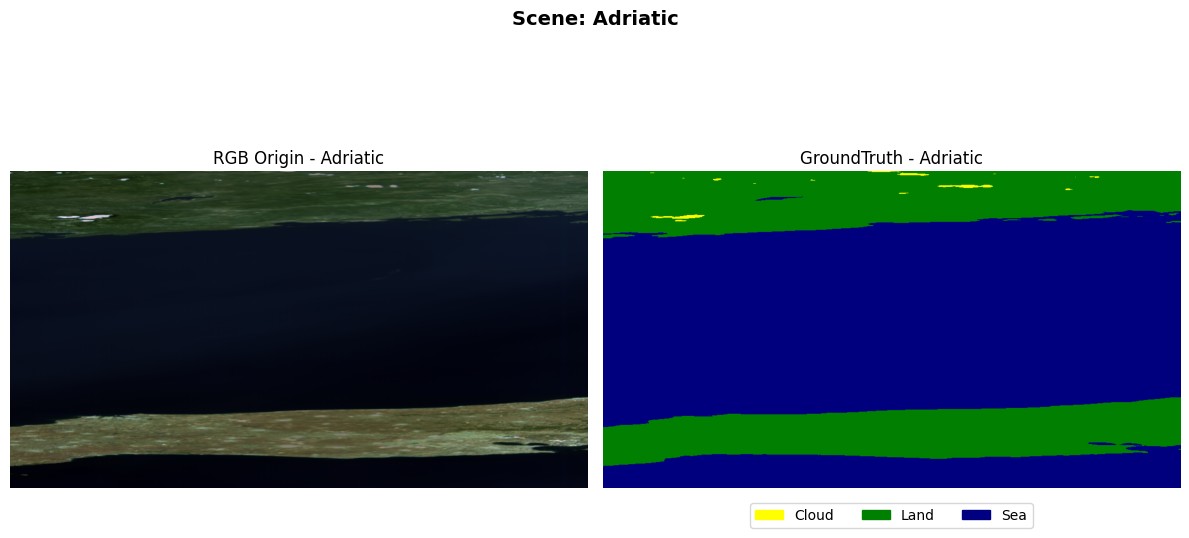

In [20]:

c1 = int(0)
if data_file == 'l1a':
    hyperspectral_data = l1a_files[c1]
    label = labels[c1]
    scene_name = reflectance_data_files[c1].split("_")[0]
elif data_file == 'l1b':
    hyperspectral_data = l1b_files[c1]
    label = labels[c1]
    scene_name = reflectance_data_files[c1].split("_")[0]
elif data_file == 'l1d':
    hyperspectral_data = l1d_files[c1]
    label = labels[c1]
    scene_name = reflectance_data_files[c1].split("_")[0]
elif data_file == 'l1d+h2':
    hyperspectral_data = h2_l1d_files[c1]
    label = labels_h2[c1]
    scene_name = hypso2_files[c1].split("_")[0]



# Check the number of unique classes in the label
unique_labels = np.unique(label)
num_classes = len(unique_labels)

# Define class names and color maps based on the number of classes
if num_classes == 4:
    class_names = {1: "Snow", 2: "Cloud", 3: "Land", 4: "Sea"}
    color_map = {
        1: (1, 1, 1),      # Snow (white)
        2: (1, 1, 0),      # Cloud (yellow)
        3: (0, 0.5, 0),    # Land (dark green)
        4: (0, 0, 0.5)     # Sea (dark blue)
    }
elif num_classes == 3:
    class_names = {1: "Cloud", 2: "Land", 3: "Sea"}
    color_map = {
        1: (1, 1, 0),      # Cloud (yellow)
        2: (0, 0.5, 0),    # Land (dark green)
        3: (0, 0, 0.5)     # Sea (dark blue)
    }
else:
    print(f"Unexpected number of classes ({num_classes}) in label.")
    exit()

# Convert color map dictionary into a ListedColormap
custom_cmap = mcolors.ListedColormap([color_map[i] for i in sorted(color_map.keys())])

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Generate RGB image
rgb_data = spectral.get_rgb(hyperspectral_data, (69, 46, 26))

# Plot the original RGB image
axes[0].imshow(rgb_data)
axes[0].set_title(f'RGB Origin - {scene_name.capitalize()}')
axes[0].axis('off')

# Plot the ground truth labels with the custom colormap
im = axes[1].imshow(label, cmap=custom_cmap)
axes[1].set_title(f'GroundTruth - {scene_name.capitalize()}')
axes[1].axis('off')

# Create legend
patches = [
    mpatches.Patch(color=color_map[label_val], label=class_names.get(label_val, f"Class {label_val}"))
    for label_val in unique_labels
]

axes[1].legend(handles=patches, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=10)

# Set the scene name in the title
plt.suptitle(f'Scene: {scene_name.capitalize()}', fontsize=14, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Apply Transformations

In [21]:

if data_file == 'l1a':
    files_to_process = l1a_files
elif data_file == 'l1b':
    files_to_process = l1b_files
elif data_file == 'l1d':
    files_to_process = l1d_files
elif data_file == 'l1d+h2':
    files_to_process = l1d_files
    h2_files_to_process = h2_l1d_files

if apply_pca:
    PROCESSING_TYPE = "pca"

    processed_images = batch_processing(
        files=files_to_process,
        num_pca_components=N_PCA,
        batch_size=BATCH_SIZE,
        processing_type=PROCESSING_TYPE
    )
    print(processed_images.shape)

    if data_file == 'l1d+h2':

        h2_processed_images = batch_processing(
            files=h2_files_to_process,
            selected_bands=selected_bands,
            num_pca_components=N_PCA,
            batch_size=BATCH_SIZE,
            processing_type=PROCESSING_TYPE
        )
        print(h2_processed_images.shape)
        h2_processed_images = h2_files_to_process

## Data Split

In [22]:
if apply_pca:
    print('Splitting processed images')
    data = processed_images
    data_labels = labels
    data_filenames = l1d_filenames
    data_label_filenames = label_filenames
else:
    print('Splitting images (No pre-processing)')
    data = files_to_process
    data_labels = labels
    data_filenames = l1d_filenames
    data_label_filenames = label_filenames

# Split into training and temporary (validation + testing)
train_images, temp_images, train_labels, temp_labels, train_filenames, temp_filenames, train_label_filenames, temp_label_filenames = train_test_split(
    data, data_labels, data_filenames, data_label_filenames,
    test_size=1 - TRAIN_SIZE, random_state=RANDOM_SEED
)

# Split temporary into validation and testing
val_images, testing_files, val_labels, testing_labels, val_filenames, testing_filenames, val_label_filenames, testing_label_filenames = train_test_split(
    temp_images, temp_labels, temp_filenames, temp_label_filenames,
    test_size=TEST_SIZE / (VALIDATION_SIZE + TEST_SIZE), random_state=RANDOM_SEED
)

if data_file == 'l1d+h2':
    testing_files = np.concatenate((testing_files, h2_processed_images if apply_pca else h2_files_to_process), axis=0)
    testing_labels = np.concatenate((testing_labels, labels_h2), axis=0)
    testing_filenames = testing_filenames + h2_filenames
    testing_label_filenames = testing_label_filenames + label_h2_filenames

train_data = PatchSet(train_images, train_labels, PATCH_SIZE, STRIDE)
val_data = PatchSet(val_images, val_labels, PATCH_SIZE, STRIDE)
test_data = TestPatchSet(testing_files, TEST_PATCH_SIZE, TEST_STRIDE)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f"DataLoaders ready✅")
print(f" Training images: {len(train_images)}")
print(f" Validation images: {len(val_images)}")
print(f" Testing images: {len(testing_files)}")

Splitting images (No pre-processing)
DataLoaders ready✅
 Training images: 10
 Validation images: 5
 Testing images: 2


## Model

In [ ]:

class WaveletCNN(nn.Module):
    def __init__(self, in_channels, class_nums, levels=DWT_WAVELET_LEVELS, base_channels=BASE_CHANNELS, dropout_rate=DROPOUT_RATE):
   
        super(WaveletCNN, self).__init__()
        self.levels = levels
        
        # Wavelet transform layers
        self.dwt = nn.ModuleList([DWTForward(J=1, mode='zero', wave=MOTHER_WAVELET) for _ in range(levels)])
        
        # Projection and convolution blocks
        self.projections = nn.ModuleList()
        self.conv_blocks = nn.ModuleList()
        
        # Keep track of output channels for each level
        self.level_channels = []
        
        for i in range(levels):
            # Calculate previous channels for feature concatenation
            prev_channels_sum = sum(self.level_channels)
            
            # Input channels include the low-pass and high-pass wavelet coefficients plus previous features
            input_channels = in_channels + 3 * in_channels + prev_channels_sum
            
            # Exponential scaling: base_channels * 2^i
            output_channels = base_channels * (2 ** i)
            self.level_channels.append(output_channels)

            self.projections.append(nn.Conv2d(input_channels, output_channels, kernel_size=1))
            self.conv_blocks.append(nn.Sequential(
                nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(output_channels),
                #nn.ReLU(inplace=True),
                nn.LeakyReLU(negative_slope=0.01, inplace=True),
                nn.Dropout(p=dropout_rate)
            ))

        # Segmentation Head
        total_channels = sum(self.level_channels)
        self.seg_head = nn.Sequential(
            nn.Conv2d(total_channels, total_channels // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(total_channels // 2),
            #nn.ReLU(inplace=True),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Conv2d(total_channels // 2, total_channels // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(total_channels // 2), 
            #nn.ReLU(inplace=True)
            nn.LeakyReLU(negative_slope=0.01, inplace=True)
        )

        # Dynamic upsampling layers
        self.upsample_layers = nn.ModuleList()
        current_channels = total_channels // 2
        
        # Create upsampling layers based on levels
        for i in range(levels):
            out_channels = current_channels // 2 if i < levels - 1 else class_nums
            self.upsample_layers.append(
                nn.ConvTranspose2d(current_channels, out_channels, kernel_size=2, stride=2)
            )
            current_channels = out_channels

    def forward(self, x):
        features = []
        low_pass = x
        
        # Wavelet processing
        for i in range(self.levels):
            low_pass, high_pass = self.dwt[i](low_pass)
            batch_size, channels, height, width = low_pass.shape
            _, high_pass_channels, subbands, _, _ = high_pass[0].shape
            high_pass = high_pass[0].view(batch_size, high_pass_channels * subbands, height, width)

            resized_features = [
                F.interpolate(feat, size=(height, width), mode='bilinear', align_corners=False)
                for feat in features
            ]

            concatenated = torch.cat([low_pass, high_pass] + resized_features, dim=1)
            projected = self.projections[i](concatenated)
            conv_out = self.conv_blocks[i](projected)
            features.append(conv_out)

        # Process features for segmentation
        smallest_height, smallest_width = features[-1].shape[2:]
        resized_features = [
            F.interpolate(feat, size=(smallest_height, smallest_width), mode='bilinear', align_corners=False)
            for feat in features
        ]
        
        out = torch.cat(resized_features, dim=1)
        out = self.seg_head(out)

        # Dynamic upsampling based on number of levels
        for upsample_layer in self.upsample_layers:
            out = upsample_layer(out)

        return out



# Initialize the model
net = WaveletCNN(in_channels=num_components , class_nums=NUM_CLASS)

# Input tensor
input_tensor = torch.randn(1, num_components,PATCH_SIZE, PATCH_SIZE)
print(f"Input tensor shape: {input_tensor.shape}")

# Model summary
summary(
    net,
    input_size=(1, num_components, PATCH_SIZE, PATCH_SIZE),
    col_names=['num_params', 'kernel_size', 'mult_adds', 'input_size', 'output_size'],
    col_width=18,
    row_settings=['var_names'],
    depth=4,
)

Input tensor shape: torch.Size([1, 120, 32, 32])


Layer (type (var_name))                  Param #            Kernel Shape       Mult-Adds          Input Shape        Output Shape
WaveletCNN (WaveletCNN)                  --                 --                 --                 [1, 120, 32, 32]   [1, 3, 32, 32]
├─ModuleList (dwt)                       --                 --                 --                 --                 --
│    └─DWTForward (0)                    --                 --                 --                 [1, 120, 32, 32]   [1, 120, 16, 16]
├─ModuleList (projections)               --                 --                 --                 --                 --
│    └─Conv2d (0)                        7,696              [1, 1]             1,970,176          [1, 480, 16, 16]   [1, 16, 16, 16]
├─ModuleList (conv_blocks)               --                 --                 --                 --                 --
│    └─Sequential (0)                    --                 --                 --                 [1, 16, 16, 1

## Training

Using device: cuda


Training::   0%|          | 0/10 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/2951 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/1476 [00:00<?, ?it/s]

Epoch 1/10 | Loss: 0.0000 | Train Acc: 0.9596 | Val Acc: 0.9570 | Val IoU: 0.8370 | LR: 0.001000 | Time: 143.06s


Train Batch:   0%|          | 0/2951 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/1476 [00:00<?, ?it/s]

Epoch 2/10 | Loss: 0.0000 | Train Acc: 0.9726 | Val Acc: 0.9532 | Val IoU: 0.8134 | LR: 0.001000 | Time: 144.09s


Train Batch:   0%|          | 0/2951 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/1476 [00:00<?, ?it/s]

Epoch 3/10 | Loss: 0.0000 | Train Acc: 0.9742 | Val Acc: 0.9578 | Val IoU: 0.8313 | LR: 0.001000 | Time: 144.95s


Train Batch:   0%|          | 0/2951 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/1476 [00:00<?, ?it/s]

Epoch 4/10 | Loss: 0.0000 | Train Acc: 0.9753 | Val Acc: 0.9631 | Val IoU: 0.8633 | LR: 0.001000 | Time: 144.83s


Train Batch:   0%|          | 0/2951 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/1476 [00:00<?, ?it/s]

Epoch 5/10 | Loss: 0.0000 | Train Acc: 0.9762 | Val Acc: 0.9623 | Val IoU: 0.8661 | LR: 0.001000 | Time: 144.73s


Train Batch:   0%|          | 0/2951 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/1476 [00:00<?, ?it/s]

Epoch 6/10 | Loss: 0.0000 | Train Acc: 0.9768 | Val Acc: 0.9586 | Val IoU: 0.8561 | LR: 0.001000 | Time: 144.73s


Train Batch:   0%|          | 0/2951 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/1476 [00:00<?, ?it/s]

Epoch 7/10 | Loss: 0.0000 | Train Acc: 0.9772 | Val Acc: 0.9498 | Val IoU: 0.7911 | LR: 0.001000 | Time: 144.41s


Train Batch:   0%|          | 0/2951 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/1476 [00:00<?, ?it/s]

Epoch 8/10 | Loss: 0.0000 | Train Acc: 0.9776 | Val Acc: 0.9600 | Val IoU: 0.8524 | LR: 0.000500 | Time: 144.81s


Train Batch:   0%|          | 0/2951 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/1476 [00:00<?, ?it/s]

Epoch 9/10 | Loss: 0.0000 | Train Acc: 0.9786 | Val Acc: 0.9628 | Val IoU: 0.8690 | LR: 0.000500 | Time: 145.04s


Train Batch:   0%|          | 0/2951 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/1476 [00:00<?, ?it/s]

Epoch 10/10 | Loss: 0.0000 | Train Acc: 0.9788 | Val Acc: 0.9617 | Val IoU: 0.8653 | LR: 0.000500 | Time: 142.09s
⏹️ Early stopping triggered at epoch 10. Best val_acc: 0.9631
🏁 Training completed in 1442.79 seconds.
🛑 Stopped at epoch 10
best model:19_03_18_21_acc_0.9631_EPOCH_3.pth


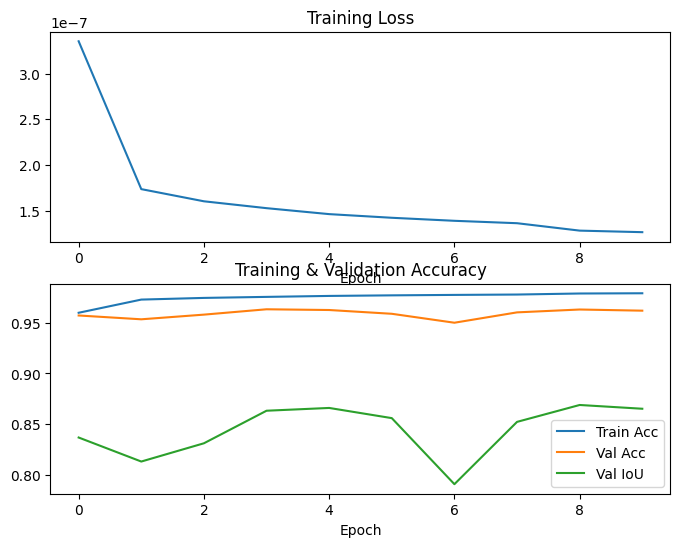

🎯 Best model retained: results\l1d\19_03_18_21_acc_0.9631_EPOCH_3.pth


In [24]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(DEVICE)
print(f"Using device: {device}")

model = WaveletCNN(num_components, class_nums=NUM_CLASS).to(device)

#optimizer = torch.optim.Adam(model.parameters(), LR, weight_decay=WEIGHT_DECAY)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)


loss_func = FocalLoss(alpha=1, gamma=2)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

loss_list, acc_list, val_acc_list, val_dice_list, val_iou_list, val_epoch_list = [], [], [], [], [], []
best_val_acc = 0.0
patience = 6


train_num = len(train_loader.dataset) * PATCH_SIZE * PATCH_SIZE
val_num = len(val_loader.dataset) * PATCH_SIZE * PATCH_SIZE
start_time = time.time()

# Initialize training log
training_log = []

try:
    for e in tqdm(range(EPOCH), desc="Training:"):
        epoch_start_time = time.time()
        model.train()
        avg_loss = 0.0
        train_acc = 0

        train_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc="Train Batch", leave=False)
        for batch_idx, (data, target) in train_progress:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            out = model(data)
            target = target - 1
            loss = loss_func(out, target)
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            _, pred = torch.max(out, dim=1)
            train_acc += (pred == target).sum().item()
            train_progress.set_postfix({"Loss": loss.item()})

        loss_list.append(avg_loss / float(train_num))
        acc_list.append(train_acc / train_num)

        model.eval()
        val_acc = 0
        val_dice = 0.0
        val_iou = 0.0
        val_progress = tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation Batch", leave=False)
        with torch.no_grad():
            for batch_idx, (data, target) in val_progress:
                data, target = data.to(device), target.to(device)
                out = model(data)
                target = target - 1
                _, pred = torch.max(out, dim=1)
                val_acc += (pred == target).sum().item()

                dice_score = dice(pred, target)
                iou_score = jaccard_index(pred, target, task='multiclass', num_classes=NUM_CLASS)

                val_dice += dice_score.item()
                val_iou += iou_score.item()

        val_acc /= val_num
        val_dice /= len(val_loader)
        val_iou /= len(val_loader)

        val_acc_list.append(val_acc)
        val_dice_list.append(val_dice)
        val_iou_list.append(val_iou)
        val_epoch_list.append(e)

        scheduler.step(val_acc_list[-1])
        current_lr = optimizer.param_groups[0]['lr']

        epoch_end_time = time.time()
        epoch_time = epoch_end_time - epoch_start_time

        epoch_output = f"Epoch {e + 1}/{EPOCH} | Loss: {loss_list[-1]:.4f} | Train Acc: {acc_list[-1]:.4f} | Val Acc: {val_acc:.4f} | Val IoU: {val_iou:.4f} | LR: {current_lr:.6f} | Time: {epoch_time:.2f}s"
        print(epoch_output)
        training_log.append(epoch_output)  # Append epoch output to training log

        # --- Model saving after each epoch ---
        now = datetime.now()
        date_time_str = now.strftime("%d_%m_%H_%M")
        save_name = os.path.join(SAVE_PATH, f"{date_time_str}_acc_{val_acc:.4f}.pth")
        torch.save(model.state_dict(), save_name)
        # --- End of model saving ---

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            early_stop_counter = 0
            best_model_epoch = e  # Keep track of the best epoch
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            stop_message = f"⏹️ Early stopping triggered at epoch {e + 1}. Best val_acc: {best_val_acc:.4f}"
            print(stop_message)
            training_log.append(stop_message)  # Append early stopping message
            break

except Exception as exc:
    error_message = f"⚠️ Training interrupted: {exc}"
    print(error_message)
    training_log.append(error_message)  # Append error message
finally:
    total_time = time.time() - start_time
    completion_message = f"🏁 Training completed in {total_time:.2f} seconds."
    print(completion_message)
    training_log.append(completion_message)  # Append completion message
    stop_epoch_message = f"🛑 Stopped at epoch {e + 1}"
    print(stop_epoch_message)
    training_log.append(stop_epoch_message)  # Append stop epoch message

    best_model_path = get_best_model(val_acc_list, val_epoch_list, SAVE_PATH)
    training_log.append(f"Best model retained: {best_model_path}")  # Append best model path

    # Save the *best* model
    best_model_path = os.path.join(SAVE_PATH, f"{date_time_str}_acc_{best_val_acc:.4f}_EPOCH_{best_model_epoch}.pth")
    torch.save(model.state_dict(), best_model_path)

    # Save training information
    configs = get_configurations()
    save_training_info(model, configs, training_log, best_val_acc)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
    ax1.plot(np.arange(len(loss_list)), loss_list, label="Training Loss")
    ax1.set_title("Training Loss")
    ax1.set_xlabel("Epoch")

    ax2.plot(np.arange(len(acc_list)), acc_list, label="Train Acc")
    ax2.plot(val_epoch_list, val_acc_list, label="Val Acc")
    ax2.plot(val_epoch_list, val_iou_list, label = "Val IoU")
    ax2.set_title("Training & Validation Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.legend()

    # Save the plot with the same name as the best model
    experiments_dir = "C:\\WaveSeg\\experiments"
    if not os.path.exists(experiments_dir):
        os.makedirs(experiments_dir)

    plot_filename = os.path.basename(best_model_path).replace(".pth", ".png")
    plot_path = os.path.join(experiments_dir, plot_filename)
    plt.savefig(plot_path)



    plt.show()

print(f"🎯 Best model retained: {best_model_path}")



### Inference and Evaluation

best model:19_03_18_21_acc_0.9631_EPOCH_3.pth
✅ Loading Best Model from: results\l1d\19_03_18_21_acc_0.9631_EPOCH_3.pth
✅ Model loaded successfully. Ready for inference!

Processing Test Image 1/2 - Scene: aquawatchplymouth_2025-03-04T10-37-14Z
Unique classes in ground truth before plotting: [1 2 3]


C:\Users\Philip Shahdadfar\AppData\Local\Temp\ipykernel_13148\1983980450.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_mode

Predicting Image 1:   0%|          | 0/1230 [00:00<?, ?it/s]

Unique classes in prediction: [0 1 2]


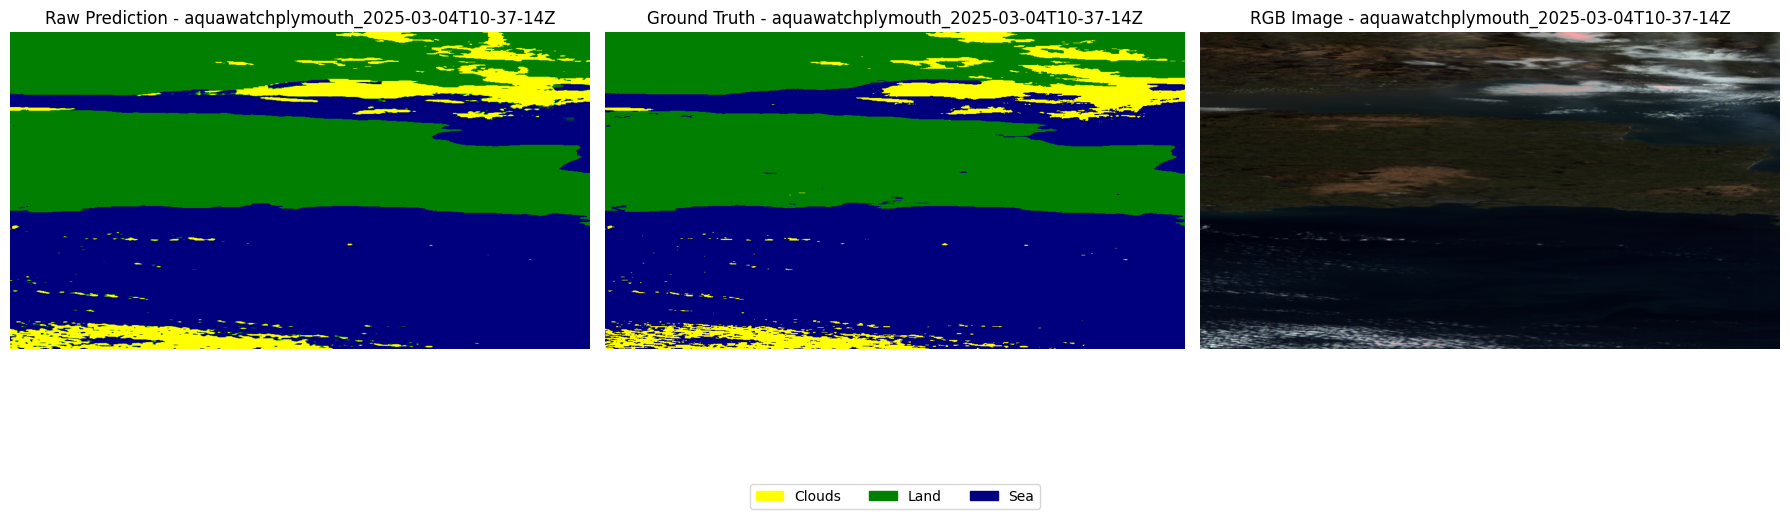

Scene: aquawatchplymouth_2025-03-04T10-37-14Z
OA: 0.9688552807281904
AA: 0.9352661379616256
Kappa: 0.9450578856694251
              precision    recall  f1-score   support

      Clouds     0.8660    0.8445    0.8551     51662
        Land     0.9604    0.9937    0.9768    274573
         Sea     0.9926    0.9676    0.9800    326781

    accuracy                         0.9689    653016
   macro avg     0.9397    0.9353    0.9373    653016
weighted avg     0.9691    0.9689    0.9688    653016


Processing Test Image 2/2 - Scene: aegean_2024-08-22T08-41-46Z
Unique classes in ground truth before plotting: [1 2 3]


Predicting Image 2:   0%|          | 0/1230 [00:00<?, ?it/s]

Unique classes in prediction: [0 1 2]


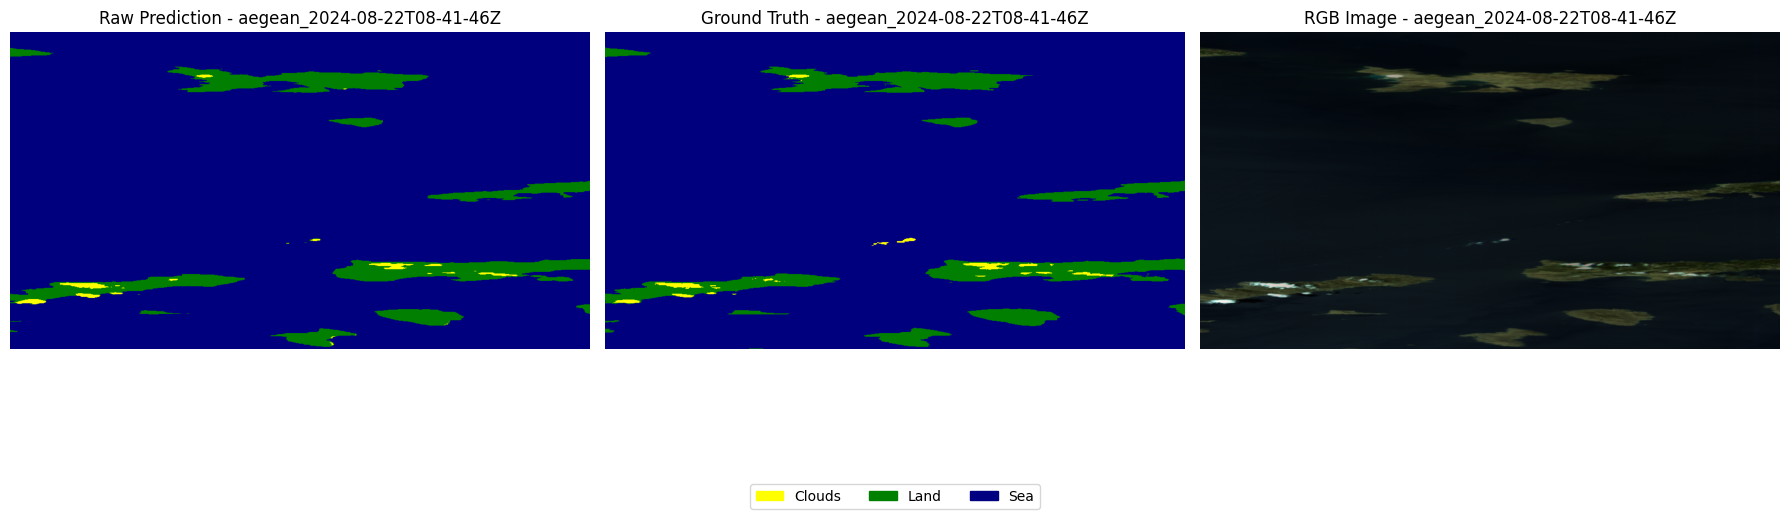

Scene: aegean_2024-08-22T08-41-46Z
OA: 0.9935024562950985
AA: 0.9000819339862905
Kappa: 0.9554533805251084
              precision    recall  f1-score   support

      Clouds     0.8725    0.7678    0.8168      2967
        Land     0.9856    0.9328    0.9584     50020
         Sea     0.9947    0.9997    0.9972    600029

    accuracy                         0.9935    653016
   macro avg     0.9509    0.9001    0.9241    653016
weighted avg     0.9934    0.9935    0.9934    653016



In [25]:
class_names = {1: "Clouds", 2: "Land", 3: "Sea"}
color_map = {
    1: (1, 1, 0),    # Clouds (yellow)
    2: (0, 0.5, 0), # Land (dark green)
    3: (0, 0, 0.5)  # Sea (dark blue)
}


custom_cmap = mcolors.ListedColormap([color_map[i] for i in sorted(color_map.keys())])


testing_label_dict = {
    os.path.basename(fname).replace("-l1a_labels.dat", ""): label
    for fname, label in zip(testing_label_filenames, testing_labels)
}

## Load the best trained model
best_model_path = get_best_model(val_acc_list, val_epoch_list, SAVE_PATH)
print(f"✅ Loading Best Model from: {best_model_path}")

best_model = WaveletCNN(num_components, class_nums=NUM_CLASS)
best_model.load_state_dict(torch.load(best_model_path, map_location=device))  # Ensure correct device

## Move model to GPU if available
best_model.to(device)
best_model.eval()  # Set model to evaluation mode

print("✅ Model loaded successfully. Ready for inference!")

for img_idx, test_img_filename in enumerate(testing_filenames):
    scene_name = os.path.basename(test_img_filename).replace('-l1d.nc', '').replace('-l1d', '') # handles both file name types
    print(f"\nProcessing Test Image {img_idx + 1}/{len(testing_filenames)} - Scene: {scene_name}")

    if scene_name in testing_label_dict:
        ground_truth = testing_label_dict[scene_name]
    else:
        print(f"❌ Warning: No matching ground truth found for {scene_name}")
        continue

    print(f"Unique classes in ground truth before plotting: {np.unique(ground_truth)}")

    test_img = testing_files[img_idx]

    test_data = TestPatchSet([test_img], patch_size=16, stride=2)
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    pred_patches = []
    confidence_scores = []

    for batch_idx, (data, image_indices) in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Predicting Image {img_idx + 1}"):
        data = data.to(device)

        out = best_model(data)
        probs = F.softmax(out, dim=1)

        max_probs, pred = torch.max(probs, dim=1)

        pred_patches.append(pred.detach().cpu().numpy())
        confidence_scores.append(max_probs.detach().cpu().numpy())

    pred_patches = np.concatenate(pred_patches, axis=0)
    confidence_scores = np.concatenate(confidence_scores, axis=0)

    original_shape = test_img.shape[:2]

    pred_map = reconstruct_image_with_confidence(
        pred_patches,
        confidence_scores,
        original_shape,
        patch_size=16,
        stride=2
    )

    print(f"Unique classes in prediction: {np.unique(pred_map)}")

    # Match scene name to corresponding L1D file using reflectance_data_files
    matching_l1d_file = None
    if scene_name in [os.path.basename(file).replace('-l1d.nc', '') for file in reflectance_data_files]:
        for reflectance_file, l1d_file in zip(reflectance_data_files, l1d_files):
            if scene_name in reflectance_file:
                matching_l1d_file = l1d_file
                break
    elif scene_name in [os.path.basename(file).replace('-l1d.nc', '') for file in hypso2_files]:
        for hypso2_file in hypso2_files:
            if scene_name in hypso2_file:
                matching_l1d_file = load_l1d_nc_cube(os.path.join(hypso2_data_path, hypso2_file))
                break

    if matching_l1d_file is not None:
        hyperspectral_data = matching_l1d_file
        rgb_image = spectral.get_rgb(hyperspectral_data, (69, 46, 26))
    else:
        print(f"❌ Warning: No matching L1D file found for {scene_name}, skipping RGB plot.")
        rgb_image = np.zeros((ground_truth.shape[0], ground_truth.shape[1], 3))  # Placeholder black image

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(pred_map, cmap=custom_cmap)
    axes[0].set_title(f'Raw Prediction - {scene_name}')
    axes[0].axis("off")

    axes[1].imshow(ground_truth, cmap=custom_cmap)
    axes[1].set_title(f'Ground Truth - {scene_name}')
    axes[1].axis("off")

    axes[2].imshow(rgb_image)
    axes[2].set_title(f'RGB Image - {scene_name}')
    axes[2].axis("off")

    unique_labels = np.unique(ground_truth)
    patches = [
        mpatches.Patch(color=color_map[label_val], label=class_names.get(label_val, f"Class {label_val}"))
        for label_val in unique_labels
    ]
    fig.legend(handles=patches, loc='lower center', bbox_to_anchor=(0.5, 0.02), ncol=3, fontsize=10)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()

    # Evaluation for each image
    test_pred = pred_map[ground_truth != 0]
    test_true = ground_truth[ground_truth != 0]

    # Adjust predictions to match ground truth labels (1, 2, 3)
    test_pred = test_pred + 1

    OA = accuracy_score(test_true, test_pred)
    AA = recall_score(test_true, test_pred, average='macro', zero_division=0)
    kappa = cohen_kappa_score(test_true, test_pred)
    report_log = f"Scene: {scene_name}\nOA: {OA}\nAA: {AA}\nKappa: {kappa}\n"
    report_log += classification_report(test_true, test_pred, target_names=[class_names[i] for i in sorted(class_names.keys())], digits=4, zero_division=0, labels=sorted(class_names.keys()))
    print(report_log)
    
    # fp = open(os.path.join(SAVE_PATH, f'{scene_name}_classification_report.txt'), 'w+')
    # fp.writelines(report_log)
    # fp.close()